<a href="https://colab.research.google.com/github/tiadwi/GoogleBangkit-MaskClassification/blob/branch_shuffle_test/Mask_NoMask_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.93):
      print("\nReached 93% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

### **Download Datasets from Kaggle**

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"randycaesario","key":"43fce69e539110549b335475f9868d55"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d 'ahmetfurkandemr/mask-datasets-v1'
! mkdir GoogleBangkit
! unzip mask-datasets-v1.zip -d GoogleBangkit

100% 753M/754M [00:23<00:00, 41.4MB/s]
100% 754M/754M [00:23<00:00, 33.7MB/s]
Archive:  mask-datasets-v1.zip
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/1.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/10.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/100.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/101.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/102.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/103.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/104.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/105.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/106.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/107.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/108.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/109.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/11.PNG  
  inflating: GoogleBangkit/Mask_Datasets/Train/Mask/110.PNG  
  inflating: GoogleBangkit/

### **Define the Data Directory**

In [4]:
base_dir = '/content/GoogleBangkit/Mask_Datasets'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')

# Directory with our training Mask/No Mask pictures
train_Mask_dir = os.path.join(train_dir, 'Mask')
train_No_Mask_dir = os.path.join(train_dir, 'No_mask')

# Directory with our validation cat/dog pictures
validation_Mask_dir = os.path.join(validation_dir, 'Mask')
validation_No_Mask_dir = os.path.join(validation_dir, 'No_mask')

In [5]:
print('total training Mask images :', len(os.listdir(      train_Mask_dir ) ))
print('total training No Mask images :', len(os.listdir(      train_No_Mask_dir ) ))

print('total validation Mask images :', len(os.listdir( validation_Mask_dir ) ))
print('total validation No Mask images :', len(os.listdir( validation_No_Mask_dir ) ))

total training Mask images : 350
total training No Mask images : 400
total validation Mask images : 150
total validation No Mask images : 200


### **Image Visualization**

In [6]:
# Now, let's see what the filenames look like in the Mask and no mask train directories 
# (file naming conventions are the same in the validation directory)

train_Mask_fnames = os.listdir( train_Mask_dir )
train_No_Mask_fnames = os.listdir( train_No_Mask_dir )

print(train_Mask_fnames[:10])
print(train_No_Mask_fnames[:10])

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

['41.PNG', '201.PNG', '133.PNG', '274.PNG', '300.PNG', '44.PNG', '338.PNG', '150.PNG', '301.PNG', '128.PNG']
['15404.png', '15671.png', '15713.png', '15449.png', '15675.png', '15530.png', '15587.png', 'Aaron_Tippin_0001.jpg', '15698.png', '15403.png']


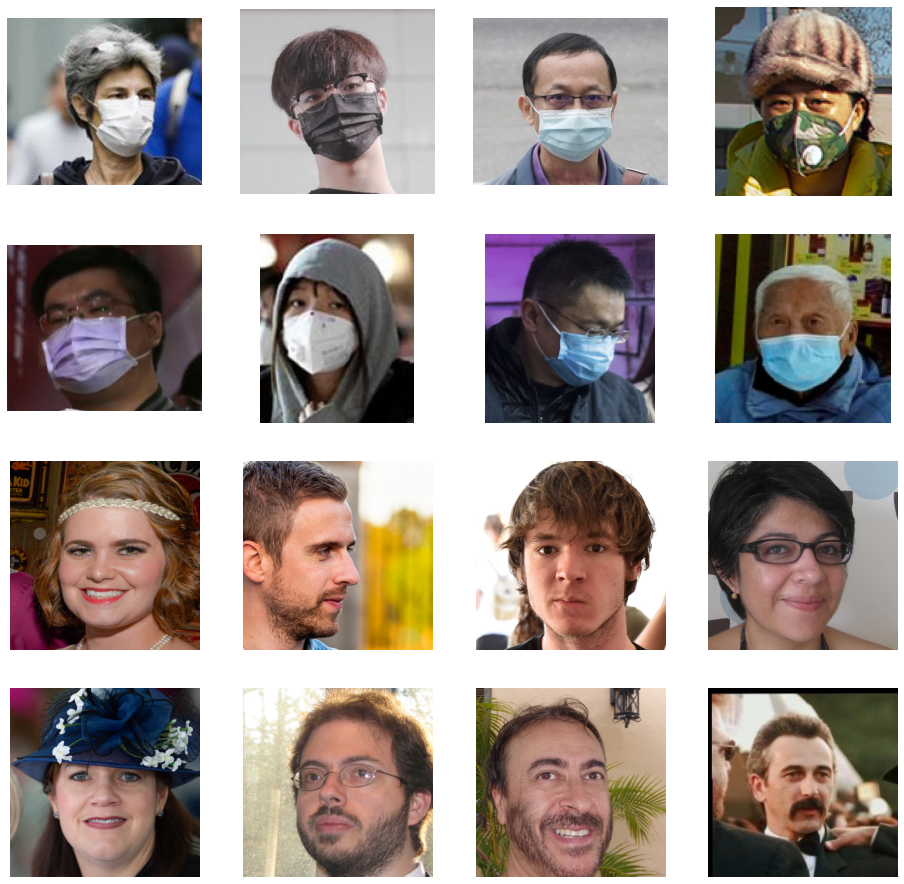

In [7]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_Mask_pix = [os.path.join(train_Mask_dir, fname) 
                for fname in train_Mask_fnames[ pic_index-8:pic_index] 
               ]

next_No_Mask_pix = [os.path.join(train_No_Mask_dir, fname) 
                for fname in train_No_Mask_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_Mask_pix+next_No_Mask_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [9]:
#@title Remixing and Shuffling the Image Dataset

import random
from shutil import copy

def absoluteFilePaths(directory):
  filelist = []
  for dirpath,_,filenames in os.walk(directory):
    for f in filenames:
      filelist.append(os.path.abspath(os.path.join(dirpath, f)))
  return filelist

mask_img = absoluteFilePaths(train_Mask_dir) + absoluteFilePaths(validation_Mask_dir)
nomask_img = absoluteFilePaths(train_No_Mask_dir) + absoluteFilePaths(validation_No_Mask_dir)

random.shuffle(mask_img)
random.shuffle(nomask_img)

!mkdir -p Shuffled_Mask_Datasets/Train/Mask Shuffled_Mask_Datasets/Train/No_mask \
Shuffled_Mask_Datasets/Validation/Mask Shuffled_Mask_Datasets/Validation/No_mask

new_train_dir = os.path.join('./Shuffled_Mask_Datasets/Train')
new_valid_dir = os.path.join('./Shuffled_Mask_Datasets/Validation')
new_train_mask_dir = os.path.join('./Shuffled_Mask_Datasets/Train/Mask')
new_train_nomask_dir = os.path.join('./Shuffled_Mask_Datasets/Train/No_mask')
new_valid_mask_dir = os.path.join('./Shuffled_Mask_Datasets/Validation/Mask')
new_valid_nomask_dir = os.path.join('./Shuffled_Mask_Datasets/Validation/No_mask')

for i in range(0,len(mask_img)):
  if i<len(os.listdir(train_Mask_dir)):
    copy(mask_img[i], new_train_mask_dir+'/'+str(i)+'.'+mask_img[i].split('.')[1])
  else:
    copy(mask_img[i], new_valid_mask_dir+'/'+str(i)+'.'+mask_img[i].split('.')[1])

for i in range(0,len(nomask_img)):
  if i<len(os.listdir(train_No_Mask_dir)):
    copy(nomask_img[i], new_train_nomask_dir+'/'+str(i)+'.'+nomask_img[i].split('.')[1])
  else:
    copy(nomask_img[i], new_valid_nomask_dir+'/'+str(i)+'.'+nomask_img[i].split('.')[1])

print('total training mask images:', len(os.listdir(new_train_mask_dir)))
print('total training no mask images:', len(os.listdir(new_train_nomask_dir)))
print('total validation mask images:', len(os.listdir(new_valid_mask_dir)))
print('total validation no mask images:', len(os.listdir(new_valid_nomask_dir)))
print('--')
print('total training images:', len(os.listdir(new_train_mask_dir))
                      + len(os.listdir(new_train_nomask_dir)))
print('total validation images:', len(os.listdir(new_valid_mask_dir))
                      + len(os.listdir(new_valid_nomask_dir)))
print('total images:', len(os.listdir(new_train_mask_dir))
                      + len(os.listdir(new_train_nomask_dir))
                      + len(os.listdir(new_valid_mask_dir))
                      + len(os.listdir(new_valid_nomask_dir)))

total training mask images: 350
total training no mask images: 400
total validation mask images: 150
total validation no mask images: 200
--
total training images: 750
total validation images: 350
total images: 1100


### **3 LAYERS CNN MODEL**

In [14]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('Mask') and 1 for the other ('No_Mask')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

### **Image Augmentation using ImageDataGenerator**

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

# The ImageGenerator rescaling, rotate and do other operations.
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        new_train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        new_valid_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit(
      train_generator,
      epochs=50,
      validation_data=validation_generator,
      callbacks=[callbacks],
      verbose=2)

Found 746 images belonging to 2 classes.
Found 347 images belonging to 2 classes.
Epoch 1/50
38/38 - 29s - loss: 0.6788 - accuracy: 0.5965 - val_loss: 0.5794 - val_accuracy: 0.6888
Epoch 2/50
38/38 - 29s - loss: 0.6229 - accuracy: 0.6609 - val_loss: 0.5077 - val_accuracy: 0.8357
Epoch 3/50
38/38 - 28s - loss: 0.5475 - accuracy: 0.7466 - val_loss: 0.5522 - val_accuracy: 0.6888
Epoch 4/50
38/38 - 29s - loss: 0.4962 - accuracy: 0.7587 - val_loss: 0.3407 - val_accuracy: 0.8761
Epoch 5/50
38/38 - 28s - loss: 0.4395 - accuracy: 0.8029 - val_loss: 0.2880 - val_accuracy: 0.8991
Epoch 6/50
38/38 - 29s - loss: 0.4089 - accuracy: 0.8043 - val_loss: 0.2513 - val_accuracy: 0.9107
Epoch 7/50
38/38 - 28s - loss: 0.3941 - accuracy: 0.8351 - val_loss: 0.5453 - val_accuracy: 0.7320
Epoch 8/50
38/38 - 29s - loss: 0.4011 - accuracy: 0.8244 - val_loss: 0.2425 - val_accuracy: 0.9020
Epoch 9/50
38/38 - 29s - loss: 0.3601 - accuracy: 0.8298 - val_loss: 0.2081 - val_accuracy: 0.9193
Epoch 10/50
38/38 - 29s - l

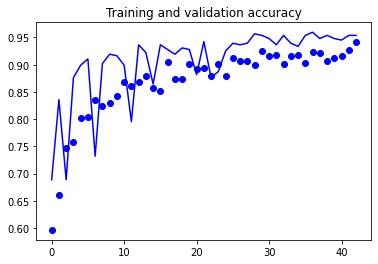

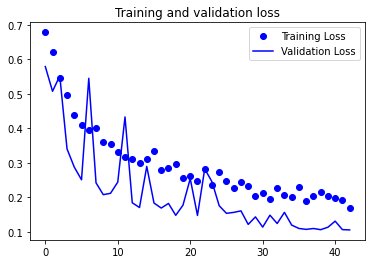

In [16]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
#@title Import Photos From Local Drive
from keras.preprocessing import image
import numpy as np

#uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=20)
  #print(classes)
  if classes[0]>0.5:
    print(fn + " is wearing a mask")
  else:
    print(fn + " is not wearing a mask")

mask1.jpg is not wearing a mask
mask2.jpg is not wearing a mask
mask3.jpg is not wearing a mask
mask4.jpg is not wearing a mask
mask5.jpg is not wearing a mask
mask6.jpg is not wearing a mask
mask7.jpg is not wearing a mask
mask8.jpg is not wearing a mask
mask9.jpg is not wearing a mask
mask10.jpg is not wearing a mask
mask11.jpg is not wearing a mask
mask12.jpg is not wearing a mask
mask13.jpg is not wearing a mask
mask14.jpg is not wearing a mask
mask15.jpg is not wearing a mask
nomask1.jpg is wearing a mask
nomask2.jpg is not wearing a mask
nomask3.jpg is not wearing a mask
nomask4.jpg is wearing a mask
nomask5.jpg is wearing a mask
nomask6.jpg is not wearing a mask
nomask7.jpg is wearing a mask
nomask8.jpg is not wearing a mask
nomask9.jpg is not wearing a mask
nomask10.jpg is wearing a mask
nomask11.jpg is not wearing a mask
nomask12.jpg is not wearing a mask
nomask13.jpg is not wearing a mask
nomask14.jpeg is wearing a mask
nomask15.jpg is wearing a mask
